# This notebook shows the optimization to find the best spectral bands for unmixing a set of endmember spectra from a hyperspectral cube.

In [1]:
%pylab inline
from pysptools import abundance_maps
import numpy
from random import sample as randsamp
import pandas as pd

import random
import urllib
import itertools
from scipy.io import loadmat
from scipy.signal import convolve2d

Populating the interactive namespace from numpy and matplotlib


# Loading ref data

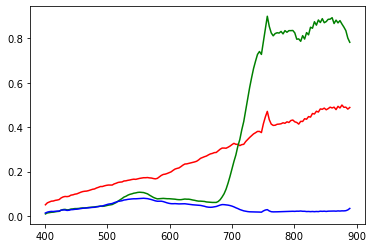

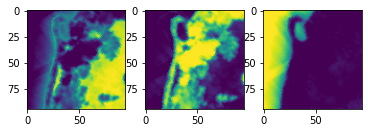

In [3]:
dataset = "samson"

d = loadmat("../input/reference-datasets/" + dataset + "/" + dataset + ".mat")
em = loadmat("../input/reference-datasets/" + dataset + "/endmembers/endmembers.mat")
dinfo = pd.read_csv("../input/reference-datasets/" + dataset + "/info.csv",header=None,index_col=None,names=["parameter",'value','unit'])

nrow = int(dinfo[dinfo['parameter'] == 'nrow'].value.values[0])
ncol = int(dinfo[dinfo['parameter'] == 'ncol'].value.values[0])

nbands = int(dinfo[dinfo['parameter'] == 'nbands'].value.values[0])
spec_start = dinfo[dinfo['parameter'] == 'spec_start'].value.values[0]
spec_end = dinfo[dinfo['parameter'] == 'spec_end'].value.values[0]

data = d['Y']
data = data / data.max()
try:
    spec_bands = d['SlectBands'].flatten()
except:
    spec_bands = arange(0,nbands)

# Define wavelength array
wavelength = linspace(spec_start,spec_end,nbands)
wavelength = wavelength[spec_bands]

if len(em['M']) > len(wavelength):
    endmembers = em['M'][spec_bands]
else:
    endmembers = em['M']

endmembers = endmembers.reshape(len(wavelength),-1)

a_map = em["A"].reshape((endmembers.shape[1],nrow,ncol)).T

hypercube = data.copy()
spectra = endmembers.T
hypercube = hypercube.reshape(len(wavelength), a_map.shape[1], a_map.shape[0]).T

# it is found the endmembers' spectra are normalised to 1, which is not the real spectra
# for the original spectra, see paper:
# Zhu, 2017, Hyperspectral Unmixing: Ground Truth Labeling, Datasets, Benchmark Performances and Survey.
spectra[0] = spectra[0] * 0.5
spectra[1] = spectra[1] * 0.9
spectra[2] = spectra[2] * 0.08

figure(1)
plot(wavelength, spectra[0], color='r')
plot(wavelength, spectra[1], color='g')
plot(wavelength, spectra[2], color='b')
plt.show()
figure(2)
subplot(1,3,1)
imshow(a_map[:,:,0])
subplot(1,3,2)
imshow(a_map[:,:,1])
subplot(1,3,3)
imshow(a_map[:,:,2])

# Accelaration algoritum

In [ ]:
def sobel(img, threshold):
    '''
    edge detection based on sobel
    threshold (0,1)
    '''
    G_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
    G_y = np.array([[-1, -2, -1],[0, 0, 0],[1, 2, 1]])
    rows = np.size(img, 0)
    columns = np.size(img, 1)
    mag = np.zeros(img.shape)
    for i in range(0, rows - 2):
        for j in range(0, columns - 2):
            v = sum(sum(G_x * img[i:i+3, j:j+3]))  # vertical
            h = sum(sum(G_y * img[i:i+3, j:j+3]))  # horizon
            mag[i+1, j+1] = np.sqrt((v ** 2) + (h ** 2))
            
    for p in range(0, rows):
        for q in range(0, columns):
            if mag[p, q] < threshold:
                mag[p, q] = 1
    return mag


def tiles (img, t, u):
    '''
    t = tile_size
    u: percentage_of_edge_pixels
    '''
    rows = np.size(img, 0)
    columns = np.size(img, 1)
    mag = np.zeros(img.shape)
    sub_area = np.zeros((t,t))      
    for p in range(0, rows):
        for q in range(0, columns):
            sub_area = img[p:p+t,q:q+t]
            area_sum = sum(sub_area)
            if area_sum > t*t*u:
                mag[p, q] = 1
    return mag

Nomalised

In [ ]:
c = sqrt(mean(hypercube**2))

hypercube = hypercube/c

In [ ]:
N,M,P = hypercube.shape

In [ ]:
sober_img = np.zeros(hypercube.shape)

for i in range(hypercube.shape[2]):
    sober_img[:,:,i] = sobel(hypercube[:,:,i], 0.4)

In [ ]:
tiles_img = np.zeros(hypercube.shape)

for i in range(hypercube.shape[2]):
    tiles_img[:,:,i] = tiles(sober_img[:,:,i],2,1)

In [ ]:
hypercube = tiles_img

# some optional merit functions

RMS

In [8]:
def compute_unmixing_accuracy(hypercube, abundance_map, endmembers, wavelength, center_wavelengths, bandwidths, return_predicted=False):
    '''
    Function to compute unmixing accuracy using NNLS spectral unmixing given a set of spectral band 
    center wavelengths and bandwidths. Assuming gaussian filter responses with a bandwidth defined
    as the FWHM.
    
    Inputs:
        hypercube (N X M x Q) - 3D synthetic hypercube.
        
        abundance_map (N x M x P)- 3D ground-truth abundance map of target. Each channel in L corresponds to the
             abundance (between 0 and 1) of the spectral signature in the spectra array. 
        
        endmembers (P x Q array) - Array of endmember signals to unmix.
        
        wavelength (1 x Q array) - Array describing the wavelength value corresponding to the spectral
            response arrays.
        
        center_wavelengths (1 x L array) - Array or list of center wavelengths for Gaussian filter responses
            to use for unmixing.
        
        bandwidths (1 x L array) - Array or list of bandwidths for Gaussian filter responses
            to use for unmixing.
        
    Outputs:
        accuracy (float) - RMS error of the unmixed abundance compared to the gruond truth
        
        predicted (optional N x M x P array) - Predicted abundance map of hypercube
    '''
    # Extract relevant dimensions
    N,M,Q = hypercube.shape
    
    # Define filter responses
    filters = [exp(-(wavelength - center_wavelengths[i])**2 / (2*(bandwidths[i]/2.355)**2)) for i in range(len(center_wavelengths))]
    
    P = len(endmembers)
    L = len(filters)
    
    # Pre-allocate arrays
    data_sig = zeros((N*M,L))
    endmember_sig = zeros((P,L))
    
    # Iterate through each filter
    for i,f in enumerate(filters):
        # Compute the signal from each filter received from the data
        # and that received from an endmember.
        data_sig[:,i] = sum(hypercube.reshape((N*M,Q))*f,axis=1) # (N*M) x L
        
        for j, e in enumerate(endmembers):
            endmember_sig[j,i] = sum(endmembers[j]*f) # P x Q
            
    # Reshape the data array into 1d array
    predicted = abundance_maps.amaps.NNLS(data_sig, endmember_sig) # (N*M x P)

    # Take RMS difference between true abundance map and computed.
    accuracy = sqrt(mean((abundance_map.reshape((N*M,len(endmember_sig)))-predicted)**2))
    
    if not accuracy or isnan(accuracy):
        return 100.
    
    if return_predicted:
        return accuracy, predicted.reshape((N,M,P))
    else:
        return accuracy

In [ ]:
def intensity_recieved(hypercube,opti_bw, opti_wavelength,wavelength, verbose=False):
    
    '''
    Inputs:
        1) hypercube (N X M x Q) - 3D synthetic hypercube.
        2) bandwidth
        3) wavelength
        4) number of block (mxXny)
        5) number of filter 
    
    
        ranking depends on three factor: 
        1) Total area of each filter 
        2) The total intensity recieved by this chanel 
        
    Output:
         a matrix with wavelength, bandwidth, intensity recieved followed the input sequence

        
    '''
    # preparation
    filter_number = len(opti_wavelength)
    N,M,Q = hypercube.shape
    hypercube = hypercube.reshape(N*M,Q)
    Intensity_recieved = zeros((N*M,Q))
    #number_of_filter 
    L = len(opti_wavelength)
    filters = []
    
    #matrxi for wavelength and bw, intensity, ranked by intensity
    matrix = zeros((L,3))
    matrix[:,0] = opti_wavelength
    matrix[:,1] = opti_bw

    # Define filter responses, add them together, not a elegant way, should improve it later
    filters = [exp(-(wavelength - opti_wavelength[i])**2 / (2*(opti_bw[i]/2.355)**2)) for i in range(len(opti_wavelength))]
       
    
 
    #print(hypercube[1].shape)
    #print(filters[0].shape)
    #plot(wavelength,filters[0],color= 'blue')
    
    #print(np.dot(hypercube[1],filters[1]))
    
    #intensity factor
    for m in range(0,L):
        for n in range(0,N*M):
            Intensity_recieved[n,m]=np.dot(hypercube[n],filters[m])
        sum_over_spectra = Intensity_recieved.sum(1)
        
        sum_over_pixel = sum_over_spectra.sum()
        matrix[m,2] = sum_over_pixel


    return matrix

In [ ]:
def compute_unmixing_weighted_accuracy(hypercube, abundance_map, endmembers, wavelength, center_wavelengths, bandwidths, return_predicted=False):
    '''
    Function to compute unmixing accuracy using NNLS spectral unmixing given a set of spectral band 
    center wavelengths and bandwidths. Assuming gaussian filter responses with a bandwidth defined
    as the FWHM.
    
    Inputs:
        hypercube (N X M x Q) - 3D synthetic hypercube.
        
        abundance_map (N x M x P)- 3D ground-truth abundance map of target. Each channel in L corresponds to the
             abundance (between 0 and 1) of the spectral signature in the spectra array. 
        
        endmembers (P x Q array) - Array of endmember signals to unmix.
        
        wavelength (1 x Q array) - Array describing the wavelength value corresponding to the spectral
            response arrays.
        
        center_wavelengths (1 x L array) - Array or list of center wavelengths for Gaussian filter responses
            to use for unmixing.
        
        bandwidths (1 x L array) - Array or list of bandwidths for Gaussian filter responses
            to use for unmixing.
        
    Outputs:
        accuracy (float) - RMS error of the unmixed abundance compared to the gruond truth
        
        predicted (optional N x M x P array) - Predicted abundance map of hypercube
    '''
    # Extract relevant dimensions
    N,M,Q = hypercube.shape
    
    # Define filter responses
    filters = [exp(-(wavelength - center_wavelengths[i])**2 / (2*(bandwidths[i]/2.355)**2)) for i in range(len(center_wavelengths))]
    
    P = len(endmembers)
    L = len(filters)
    
    # Pre-allocate arrays
    data_sig = zeros((N*M,L))
    endmember_sig = zeros((P,L))
    
    
    # Iterate through each filter
    for i,f in enumerate(filters):
        # Compute the signal from each filter received from the data
        # and that received from an endmember.
        data_sig[:,i] = sum(hypercube.reshape((N*M,Q))*f,axis=1) # (N*M) x L
        for j, e in enumerate(endmembers):
            endmember_sig[j,i] = sum(endmembers[j]*f) # P x Q

            
    # Reshape the data array into 1d array
    predicted = abundance_maps.amaps.NNLS(data_sig, endmember_sig) # (N*M x P)
    
    ranked = intensity_recieved(hypercube,bandwidths, center_wavelengths,wavelength, verbose=False)
    weight_sq_before_normalized = (ranked[:,2])
    weight = sqrt(weight_sq_before_normalized/sum(weight_sq_before_normalized))

    # Take RMS difference between true abundance map and computed.
    difference = abundance_map.reshape((N*M,len(endmember_sig)))-predicted
    
    for k in range(0,L):
        weight_difference = difference[:,k]* weight[k] 
        
    
    accuracy = sqrt(mean((weight_difference)**2))
    
    if not accuracy or isnan(accuracy):
        return 100.
    
    if return_predicted:
        return accuracy, predicted.reshape((N,M,P))
    else:
        return accuracy

In [ ]:
def compute_unmixing_map_weighted_accuracy(hypercube, abundance_map, endmembers, wavelength, center_wavelengths, bandwidths, return_predicted=False):
    '''
    Function to compute unmixing accuracy using NNLS spectral unmixing given a set of spectral band 
    center wavelengths and bandwidths. Assuming gaussian filter responses with a bandwidth defined
    as the FWHM.
    
    Inputs:
        hypercube (N X M x Q) - 3D synthetic hypercube.
        
        abundance_map (N x M x P)- 3D ground-truth abundance map of target. Each channel in L corresponds to the
             abundance (between 0 and 1) of the spectral signature in the spectra array. 
        
        endmembers (P x Q array) - Array of endmember signals to unmix.
        
        wavelength (1 x Q array) - Array describing the wavelength value corresponding to the spectral
            response arrays.
        
        center_wavelengths (1 x L array) - Array or list of center wavelengths for Gaussian filter responses
            to use for unmixing.
        
        bandwidths (1 x L array) - Array or list of bandwidths for Gaussian filter responses
            to use for unmixing.
        
    Outputs:
        accuracy (float) - RMS error of the unmixed abundance compared to the gruond truth
        
        predicted (optional N x M x P array) - Predicted abundance map of hypercube
    '''
    # Extract relevant dimensions
    N,M,Q = hypercube.shape
    
    # Define filter responses
    filters = [exp(-(wavelength - center_wavelengths[i])**2 / (2*(bandwidths[i]/2.355)**2)) for i in range(len(center_wavelengths))]
    
    P = len(endmembers)
    L = len(filters)
    
    # Pre-allocate arrays
    data_sig = zeros((N*M,L))
    endmember_sig = zeros((P,L))
    
    
    # Iterate through each filter
    for i,f in enumerate(filters):
        # Compute the signal from each filter received from the data
        # and that received from an endmember.
        data_sig[:,i] = sum(hypercube.reshape((N*M,Q))*f,axis=1) # (N*M) x L
        for j, e in enumerate(endmembers):
            endmember_sig[j,i] = sum(endmembers[j]*f) # P x Q

            
    # Reshape the data array into 1d array
    predicted = abundance_maps.amaps.NNLS(data_sig, endmember_sig) # (N*M x P)

    # Take RMS difference between true abundance map and computed.
    difference = abundance_map.reshape((N*M,len(endmember_sig)))-predicted
    
    for k in range(0,L):
        # w
        weight = sqrt(mean(difference[:,k])**2)
        # w*x
        weight_difference = difference[:,k]* weight[k]
    
    accuracy = sqrt(mean((weight_difference)**2))
    
    if not accuracy or isnan(accuracy):
        return 100.
    
    if return_predicted:
        return accuracy, predicted.reshape((N,M,P))
    else:
        return accuracy

In [ ]:
from scipy.stats import entropy

def compute_unmixing_accuracy_entropy_first_option(hypercube, abundance_map, endmembers, wavelength, center_wavelengths, bandwidths, return_predicted=False):
    '''
    Function to compute unmixing accuracy using NNLS spectral unmixing given a set of spectral band 
    center wavelengths and bandwidths. Assuming gaussian filter responses with a bandwidth defined
    as the FWHM.
    
    Inputs:
        hypercube (N X M x Q) - 3D synthetic hypercube.
        
        abundance_map (N x M x P)- 3D ground-truth abundance map of target. Each channel in L corresponds to the
             abundance (between 0 and 1) of the spectral signature in the spectra array. 
        
        endmembers (P x Q array) - Array of endmember signals to unmix.
        
        wavelength (1 x Q array) - Array describing the wavelength value corresponding to the spectral
            response arrays.
        
        center_wavelengths (1 x L array) - Array or list of center wavelengths for Gaussian filter responses
            to use for unmixing.
        
        bandwidths (1 x L array) - Array or list of bandwidths for Gaussian filter responses
            to use for unmixing.
        
    Outputs:
        accuracy (float) - RMS error of the unmixed abundance compared to the gruond truth
        
        predicted (optional N x M x P array) - Predicted abundance map of hypercube
    '''
    # Extract relevant dimensions
    N,M,Q = hypercube.shape
    
    # Define filter responses
    filters = [exp(-(wavelength - center_wavelengths[i])**2 / (2*(bandwidths[i]/2.355)**2)) for i in range(len(center_wavelengths))]
    
    P = len(endmembers)
    L = len(filters)
    
    # Pre-allocate arrays
    data_sig = zeros((N*M,L))
    endmember_sig = zeros((P,L))
    
    # Iterate through each filter
    for i,f in enumerate(filters):
        # Compute the signal from each filter received from the data
        # and that received from an endmember.
        data_sig[:,i] = sum(hypercube.reshape((N*M,Q))*f,axis=1) # (N*M) x L
        
        for j, e in enumerate(endmembers):
            endmember_sig[j,i] = sum(endmembers[j]*f) # P x Q
            
    # Reshape the data array into 1d array
    predicted = abundance_maps.amaps.NNLS(data_sig, endmember_sig) # (N*M x P)

    # Take entropy between true abundance map and predicted abundance map.
    x = predicted
    y = abundance_map.reshape((N*M,len(endmember_sig)))
    difference =  numpy.absolute((x - y))
    
    #assume the difference followes the guassian distributioin
    #standard div = 0.5, this is a parameter change with dataset, 0.5 for the simple gussian dataset
    #/. not a good assumption, should think it later
    
    sigma = 0.5
    p = exp(-(difference)**2/(2*sigma**2))

    acc = entropy([p,1-p], base=2)
    
    accuracy = acc.sum(axis=0)
    accuracy = accuracy.sum()

    
    if return_predicted:
        return accuracy, predicted.reshape((N,M,P))
    else:
        return accuracy

In [ ]:
from scipy.stats import entropy

def compute_unmixing_accuracy_entropy_second_option(hypercube, abundance_map, endmembers, wavelength, center_wavelengths, bandwidths, return_predicted=False):
    '''
    Function to compute unmixing accuracy using NNLS spectral unmixing given a set of spectral band 
    center wavelengths and bandwidths. Assuming gaussian filter responses with a bandwidth defined
    as the FWHM.
    
    Inputs:
        hypercube (N X M x Q) - 3D synthetic hypercube.
        
        abundance_map (N x M x P)- 3D ground-truth abundance map of target. Each channel in L corresponds to the
             abundance (between 0 and 1) of the spectral signature in the spectra array. 
        
        endmembers (P x Q array) - Array of endmember signals to unmix.
        
        wavelength (1 x Q array) - Array describing the wavelength value corresponding to the spectral
            response arrays.
        
        center_wavelengths (1 x L array) - Array or list of center wavelengths for Gaussian filter responses
            to use for unmixing.
        
        bandwidths (1 x L array) - Array or list of bandwidths for Gaussian filter responses
            to use for unmixing.
        
    Outputs:
        accuracy (float) - RMS error of the unmixed abundance compared to the gruond truth
        
        predicted (optional N x M x P array) - Predicted abundance map of hypercube
    '''
    # Extract relevant dimensions
    N,M,Q = hypercube.shape
    
    # Define filter responses
    filters = [exp(-(wavelength - center_wavelengths[i])**2 / (2*(bandwidths[i]/2.355)**2)) for i in range(len(center_wavelengths))]
    
    P = len(endmembers)
    L = len(filters)
    
    # Pre-allocate arrays
    data_sig = zeros((N*M,L))
    endmember_sig = zeros((P,L))
    
    # Iterate through each filter
    for i,f in enumerate(filters):
        # Compute the signal from each filter received from the data
        # and that received from an endmember.
        data_sig[:,i] = sum(hypercube.reshape((N*M,Q))*f,axis=1) # (N*M) x L
        
        for j, e in enumerate(endmembers):
            endmember_sig[j,i] = sum(endmembers[j]*f) # P x Q
            
    # Reshape the data array into 1d array
    predicted = abundance_maps.amaps.NNLS(data_sig, endmember_sig) # (N*M x P)

    # Take entropy between true abundance map and computed.
    x = predicted
    y = abundance_map.reshape((N*M,len(endmember_sig)))
    # rescale this by a factor of 2
    p = 0.5 * numpy.absolute(x - y)
    acc = entropy([p,1-p], base=2)
    accuracy = mean(sqrt(acc**2))
    
    if return_predicted:
        return accuracy, predicted.reshape((N,M,P))
    else:
        return accuracy

In [ ]:
from scipy.fft import fft, ifft
import numpy as np

def compute_unmixing_accuracy_fourier(hypercube, abundance_map, endmembers, wavelength, center_wavelengths, bandwidths, return_predicted=False):
    '''
    Function to compute unmixing accuracy using NNLS spectral unmixing given a set of spectral band 
    center wavelengths and bandwidths. Assuming gaussian filter responses with a bandwidth defined
    as the FWHM.
    
    Inputs:
        hypercube (N X M x Q) - 3D synthetic hypercube.
        
        abundance_map (N x M x P)- 3D ground-truth abundance map of target. Each channel in L corresponds to the
             abundance (between 0 and 1) of the spectral signature in the spectra array. 
        
        endmembers (P x Q array) - Array of endmember signals to unmix.
        
        wavelength (1 x Q array) - Array describing the wavelength value corresponding to the spectral
            response arrays.
        
        center_wavelengths (1 x L array) - Array or list of center wavelengths for Gaussian filter responses
            to use for unmixing.
        
        bandwidths (1 x L array) - Array or list of bandwidths for Gaussian filter responses
            to use for unmixing.
        
    Outputs:
        accuracy (float) - RMS error of the unmixed abundance compared to the gruond truth
        
        predicted (optional N x M x P array) - Predicted abundance map of hypercube
    '''
    # Extract relevant dimensions
    N,M,Q = hypercube.shape
    
    # Define filter responses
    filters = [exp(-(wavelength - center_wavelengths[i])**2 / (2*(bandwidths[i]/2.355)**2)) for i in range(len(center_wavelengths))]
    
    P = len(endmembers)
    L = len(filters)
    
    # Pre-allocate arrays
    data_sig = zeros((N*M,L))
    endmember_sig = zeros((P,L))
    
    # Iterate through each filter
    for i,f in enumerate(filters):
        # Compute the signal from each filter received from the data
        # and that received from an endmember.
        data_sig[:,i] = sum(hypercube.reshape((N*M,Q))*f,axis=1) # (N*M) x L
        
        for j, e in enumerate(endmembers):
            endmember_sig[j,i] = sum(endmembers[j]*f) # P x Q
            
    # Reshape the data array into 1d array
    predicted = abundance_maps.amaps.NNLS(data_sig, endmember_sig) # (N*M x P)

    # Take entropy between true abundance map and computed.
    x = predicted
    y = abundance_map.reshape((N*M,len(endmember_sig)))
    xf = fft(x)
    yf = fft(y)

    accuracy = sqrt(mean((np.real(yf-xf))**2))
       
    if return_predicted:
        return accuracy, predicted.reshape((N,M,P))
    else:
        return accuracy

# Functions for spectral optimization

In [9]:
def increment_position(hypercube,abundance_map, endmembers, wavelength, score, inc, pmax, pmin, score_function, bands, bws, i, j, verbose=False):
    '''
    Helper function to optimize the central wavelengths of spectral bands. Adjusts the center wavelength in one direction
    and compares to the previous result.
    '''
    if bands[i,j] >= pmax:
        bands[i,j] = pmax
        if verbose:
            print("Band location is at the maximum limit.")
        return score, bands, bws
    elif bands[i,j] <= pmin:
        bands[i,j] = pmin
        if verbose:
            print("Band location is at the minimum limit.")
        return score, bands, bws
    else:
        bands[i,j] += inc
        new_score = score_function(hypercube,abundance_map, endmembers, wavelength, bands[i], bws[i])
        if new_score < score:
            if verbose:
                print("Position adjustment resulted in previous score of %.3f improving to %.3f." %(score, new_score))
            return increment_position(hypercube,abundance_map, endmembers, wavelength, new_score, inc, pmax, pmin, score_function, bands, bws, i, j,verbose=verbose)
        else:
            if verbose:
                if inc < 0:
                    print("Convergence reached for band position adjustment in negative direction.")
                else:
                    print("Convergence reached for band position adjustment in positive direction.")
            bands[i,j] -= inc
            return score, bands, bws
        
def increment_bandwidth(hypercube,abundance_map, endmembers, wavelength, score, inc, bmax, bmin, score_function, bands, bws, i, j,verbose=False):
    '''
    Helper function to optimize the bandwidths of spectral bands. Adjusts the bandwidth in one direction
    and compares to the previous result.
    '''
    if bws[i,j] >= bmax:
        bws[i,j] = bmax
        if verbose:
            print("Bandwidth is at the maximum limit.")
        return score, bands, bws
    elif bws[i,j] <= bmin:
        bws[i,j] = bmin
        if verbose:
            print("Bandwidth is at the minimum limit.")
        return score, bands, bws
    else:
        bws[i,j] += inc
        new_score = score_function(hypercube,abundance_map, endmembers, wavelength, bands, bws[i])
        if new_score < score:
            if verbose:
                print("Bandwidth adjustment resulted in previous score of %.3f improving to %.3f." %(score, new_score))
            return increment_bandwidth(new_score, inc, bmax, bmin, score_function, bands, bws, i, j,verbose=verbose)
        else:
            if verbose:
                if inc < 0:
                    print("Convergence reached for bandwidth adjustment in negative direction.")
                else:
                    print("Convergence reached for bandwidth adjustment in positive direction.")
            bws[i,j] -= inc
            return score, bands, bws

def refine_position(hypercube,abundance_map,endmembers,wavelength, bands, bws, maxiter=20,score_function=compute_unmixing_accuracy,pstep=2,verbose=False):
    '''
    Helper function to optimize the central wavelengths of spectral bands. This function effectively conducts a gradient
    descent optimization to adjust the center wavelength until a local minimum is reached.
    '''
    old_ps = zeros_like(bands) # Empty array to track changes
    n = 0 # index of iterations

    # First, iterate through positions
    while any(old_ps != bands) and n < maxiter:
        old_ps = bands.copy()
        n += 1
        if verbose:
            print("Performing position refinement iteration number %d." %n)
                    
        for i, band in enumerate(bands):
            score = score_function(hypercube,abundance_map, endmembers, wavelength, band, bws[i])

            for j, p in enumerate(band):
                if verbose:
                    print("Refining position of band %.1f nm. Beginning score of %.3f." % (p,score))
                score, bands, bws = increment_position(hypercube,abundance_map, endmembers, wavelength,score, pstep, p+30, p-30, score_function, bands, bws, i ,j,verbose=verbose)
                score, bands, bws = increment_position(hypercube,abundance_map, endmembers, wavelength, score, -1*pstep, p+30, p-30, score_function, bands, bws, i, j,verbose=verbose)

    if verbose:
        print("Final band locations for this loop are ",bands)

    return bands, bws,score

        
def refine_bandwidth(hypercube,abundance_map,endmembers,wavelength, bands, bws , maxiter=20,score_function=compute_unmixing_accuracy,bstep=2,bw_max=50.,bw_min=20.,verbose=False):              
    '''
    Helper function to optimize the bandwidth of spectral bands. This function effectively conducts a gradient
    descent optimization to adjust the bandwidth until a local minimum is reached.
    '''
    old_bws = zeros_like(bws) # empty array to track changes
    n = 0 # index of iterations
            
    # Now, through bandwidths
    while any(old_bws != bws) and n < maxiter:
        old_bws = bws.copy()
        n += 1
        if verbose:
            print("Performing bandwidth refinement iteration number %d." %n)
        for i, band in enumerate(bands):
                   
            score = score_function(hypercube,abundance_map, endmembers, wavelength, band, bws[i])
            for j, z in enumerate(band):
                if verbose:
                    print("Refining bandwidth of band %.1f nm. Beginning score of %.3f." % (z, score))
                score, bands, bws  = increment_bandwidth(hypercube,abundance_map, endmembers, wavelength, score, bstep, bw_max, bw_min, score_function, bands, bws, i, j,verbose=verbose)
                score, bands, bws  = increment_bandwidth(hypercube,abundance_map, endmembers, wavelength, score, -1*bstep, bw_max, bw_min, score_function, bands, bws, i, j,verbose=verbose) # lazy way to check both directions
                
    if verbose:
        print("Final bandwidths for this loop are ",bws)
    return bands, bws,score

In [10]:
def optimize_spectral_bands(hypercube, abundance_map, endmembers, wavelength, N_filters, bw_max=50., bw_min=10., bstep=2., pstep=2.,random_sampling=False, n_iter=1000, loops=10,merit_function="unmixing",verbose=False):
        '''
        Optimize the spectral band position and bandwidth. Begins by stochastically sampling the 
        space of possible options. The top 5 results are then retained and a gradient descent
        approach is taken to convergene on the optimal result. The function returns the best 
        result, along with the merit function score.

        Inputs:
            hypercube (N X M x Q array) - 3D synthetic hypercube.

            abundance_map (N x M x P array)- 3D abundance map of target. Each channel in L corresponds to the
                 abundance (between 0 and 1) of the spectral signature in the spectra array. 

            endmembers (P x Q array) - Array of endmember signals to unmix.

            wavelength (1 x Q array) - Array describing the wavelength value corresponding to the spectral
                response arrays.
                
            N_filters (int): Maximum number of spectral bands. (currently fixed)

            bw_max (optional float, default=50): Maximum allowable bandwidth in nanometers for a spectral band.

            bw_min (optional float, default=5): Minimum allowable bandwidth in nanometers for a spectral band.

            bstep (optional float, default=2): Step-size in nanometers to take when optimzing spectral bands.

            random_sampling (optional Boolean, default=False)

            n_iter (optional int, default=10000): Number of iterations for the stochastic sampling step.
            
            loops (optinal int, default=10): Number of gradient descent optimization loops.

            merit_function (optional string, default="unmixing"): Merit function to use in
                the optimization. The options are:
                   'unmixing': Spectral unmixing accuracy. Minimizes the root-sum-squared difference
                       between the true endmember abundance and that obtained by NNLS unmixing.

            verbose (optional boolean, default=False): Print out relevant information
              as optimization proceeds. TODO: Set verbosity levels of 0-4 for different amounts
              of output information.

        Returns:
            center_wavelengths (1 x N_filters array) - Array describing center wavelengths of optimal
                filter set.
            
            bandwidths (1 x N_filters array) - Array describing bandwidths of optimal
                filter set.
        '''
        # Initial bandwidth will be halfway between max and min
        bw_init = (bw_max - bw_min)/2.
        
        # Generate empty arrays for stochastic optimization step.
        band_list = zeros((n_iter,N_filters))
        dist_list = zeros(n_iter)

        # TODO: Implement other merit functions
        if merit_function == "entropy_gussian":
            score_function = compute_unmixing_accuracy_entropy_first_option
            print('entropy_sigma')
        elif merit_function == "reconstraction":
            score_function = compute_hypercube_accuracy
            print('"reconstraction"')
        elif merit_function == "weighted":
            score_function = compute_unmixing_weighted_accuracy
            print('"weighted"')
        elif merit_function == "entropy_linear":
            score_function = compute_unmixing_accuracy_entropy_second_option
            print('entropy_linear')
        elif merit_function == "DFT":
            score_function = compute_unmixing_accuracy_fourier
            print('DFT')
        else :
            score_function = compute_unmixing_accuracy
            print('rms')
            
            
        if random_sampling == True:
            if verbose:
                print("Beginning stochastic optimization of band position with %d iterations." %n_iter)
            for i in range(n_iter):
                if verbose and not i % 100:
                    print("Stochastic optimization iteration %d." %i)
                # Generate the random sampling of spectral bands over wavelegnth range
                sbands = randsamp(range(int(wavelength[0]),int(wavelength[-1]), int(bw_init*2)), N_filters)

                dist = score_function(hypercube,abundance_map, endmembers, wavelength, sbands, ones(N_filters)*bw_init)
                dist_list[i] = dist
                band_list[i,:] = sbands

            # Sort according to accuracy
            dist_sorted = dist_list[dist_list.argsort()]
            bands_sorted = band_list[dist_list.argsort()]

            bands = bands_sorted[:5] # take top 5
            bws = ones_like(bands)*bw_init
            print(bands)
            
            if verbose:
                print("Stochastic optimization complete. Initializing gradient descent with top 5 candidates.")
                print(bands)
        else:
            # Evenly space the array
            if verbose:
                print("Initializing with evenly spaced band array.")
            bands = linspace(wavelength[0]+bw_init*2,wavelength[-1]-bw_init*2,N_filters).reshape(1,N_filters)
            bws = ones_like(bands)*bw_init
                
        if verbose:
            print("Beginning gradient-based optimization of bandwidth.")
            
        for k in range(loops):
            if verbose:
                print("Performing iteration loop %d of %d." %(k, loops))
            bands, bws,acc = refine_position(hypercube,abundance_map,endmembers,wavelength,bands, bws, score_function=score_function, pstep=2.,verbose=verbose)
            bands, bws,acc = refine_bandwidth(hypercube,abundance_map,endmembers,wavelength,bands, bws,score_function=score_function, bw_max=50., bw_min=20., bstep=2.,verbose=verbose)
            print(acc)
            """
            if acc < 0.0001:
                return bands, bws
            else:
                lower_limit = wavelength[0]
                upper_limit = wavelength[-1]

                for sets in bands:
                    for number in sets:
                        if number < lower_limit:
                            print('one filter reach lower limit, careful')
                            # restart the loop
                            bands = bands_sorted[5:10]
                            print('restart at ',bands)
                            k = k-1
                            if k < -1:
                                print('failed')
                                return bands, bws
                                

                        elif number > upper_limit:
                            print('one filter reach upper limit, careful')
                            # restart the loop
                            bands_sorted[5:10]
                            print('restart at ',bands)
                            k = k-1
                            if k < -1:
                                print('failed')
                                return bands, bws
                        else:
                            k = k 
                            """
            print('running ',k, 'th loop')

        
        return bands, bws

# Running the optimization loops

In [11]:
'''cut it to save time '''
a_map = a_map[20:60,20:60,:]
hypercube = hypercube[20:60,20:60,:]

In [12]:
start = time.time()

bands,bws = optimize_spectral_bands(hypercube,a_map,spectra,wavelength,3,verbose=False,loops=5,merit_function="rms",random_sampling=True)

end = time.time()
print('time cost(in seconds)',end-start)

rms
[[881. 601. 561.]
 [561. 601. 881.]
 [601. 561. 881.]
 [561. 881. 601.]
 [881. 601. 561.]]
0.20381258955490686
running  0 th loop
0.20381258955490686
running  1 th loop
0.20381258955490686
running  2 th loop
0.20381258955490686
running  3 th loop
0.20381258955490686
running  4 th loop
time cost(in seconds) 6.801972389221191


In [13]:
print(bands, bws)

[[885. 597. 577.]
 [577. 597. 885.]
 [597. 577. 885.]
 [577. 885. 597.]
 [885. 597. 577.]] [[20. 20. 20.]
 [20. 20. 20.]
 [20. 20. 20.]
 [20. 20. 20.]
 [20. 20. 20.]]


In [16]:
def filter_response(cw, bws):
    '''
    Helper function to generate NORMALISED filter response
    '''
    filters = array([exp(-0.5*((wavelength - cw[i])/(bws[i]/2.355))**2) for i in range(len(cw))])
        
    return filters

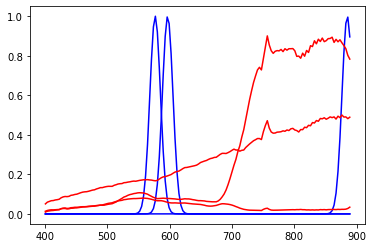

In [17]:
set_3 = filter_response([577. ,597. ,885.], [20, 20, 20])

plot(wavelength, set_3.T,'b')
plot(wavelength, spectra.T,'r')

# put the best filter set back to unmixing rms to evaluate the uncertainty introduced by this merit function 

In [ ]:
def compute_unmixing_accuracy_scale_back(hypercube, abundance_map, endmembers, wavelength, center_wavelengths, bandwidths, return_predicted=False):
    '''
    Function to compute unmixing accuracy using NNLS spectral unmixing given a set of spectral band 
    center wavelengths and bandwidths. Assuming gaussian filter responses with a bandwidth defined
    as the FWHM.
    
    Inputs:
        hypercube (N X M x Q) - 3D synthetic hypercube.
        
        abundance_map (N x M x P)- 3D ground-truth abundance map of target. Each channel in L corresponds to the
             abundance (between 0 and 1) of the spectral signature in the spectra array. 
        
        endmembers (P x Q array) - Array of endmember signals to unmix.
        
        wavelength (1 x Q array) - Array describing the wavelength value corresponding to the spectral
            response arrays.
        
        center_wavelengths (1 x L array) - Array or list of center wavelengths for Gaussian filter responses
            to use for unmixing.
        
        bandwidths (1 x L array) - Array or list of bandwidths for Gaussian filter responses
            to use for unmixing.
        
    Outputs:
        accuracy (float) - RMS error of the unmixed abundance compared to the gruond truth
        
        predicted (optional N x M x P array) - Predicted abundance map of hypercube
    '''
    # Extract relevant dimensions
    N,M,Q = hypercube.shape
    
    # Define filter responses
    filters = [exp(-(wavelength - center_wavelengths[i])**2 / (2*(bandwidths[i]/2.355)**2)) for i in range(len(center_wavelengths))]
    
    P = len(endmembers)
    L = len(filters)
    
    # Pre-allocate arrays
    data_sig = zeros((N*M,L))
    endmember_sig = zeros((P,L))
    
    
    # Iterate through each filter
    for i,f in enumerate(filters):
        # Compute the signal from each filter received from the data
        # and that received from an endmember.
        data_sig[:,i] = sum(hypercube.reshape((N*M,Q))*f,axis=1) # (N*M) x L
        for j, e in enumerate(endmembers):
            endmember_sig[j,i] = sum(endmembers[j]*f) # P x Q

            
    # Reshape the data array into 1d array
    predicted = abundance_maps.amaps.NNLS(data_sig, endmember_sig) # (N*M x P)

    # Take RMS difference between true abundance map and computed.
    accuracy = sqrt(mean((abundance_map.reshape((N*M,len(endmember_sig)))-predicted)**2))
    
    if not accuracy or isnan(accuracy):
        return 100.
    
    if return_predicted:
        return accuracy, predicted.reshape((N,M,P))
    else:
        return accuracy

In [ ]:
center_wavelengths = bands[0].tolist()

In [ ]:
bandwidths = bws[0].tolist()

In [ ]:
center_wavelengths

In [ ]:
acc = compute_unmixing_accuracy(hypercube, a_map, spectra, wavelength, center_wavelengths, bandwidths)

In [ ]:
acc

In [ ]:
#np.save("../input/Noise_hypercube/hypercube_20210217_0.3_noise",hypercube)